<a href="https://colab.research.google.com/github/gayatripadmani/Chatbot-Data-Classification-/blob/main/Copy_of_vtech_itsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/vtech_itsm

/content/drive/MyDrive/Colab Notebooks/vtech_itsm


In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import re
import nltk
import tensorflow as tf
import tensorflow.keras as keras
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, SpatialDropout1D, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

In [4]:
# load dataset
data = pd.read_csv('vtech_itsm_data.csv')

In [5]:
# top 5 rows display
data.head()

,phrases,intent_name
0,Further Assistance is not Required,Further_Help_Not_Required
1,dont require further assistance,Further_Help_Not_Required
2,Further Help not required,Further_Help_Not_Required
3,"No, I don't need further assistance.",Further_Help_Not_Required
4,don't require further assistance,Further_Help_Not_Required


In [6]:
data.sample(10)

,phrases,intent_name
7034,Items that have been deleted but not filled,Fn_Remove_All_Deleted_Items_OF
846,Can you deinstall program,Fn_Software_UninstallSWApplication_SM
564,Display group policy operations,Fn_Perform_Group_Policy_Operations_AD
159,Can you aaddress me in adding new user to AD,Fn_AccessSupport_CreateADUser_AD
6300,Could you please guide me on how to remove app...,Fn_PerfImprovement_StartupApps_PI
1126,We require report on software inventory,Fn_Software_InventorySWApplication_SM
802,"In order to use a laptop, I must download soft...",Fn_Software_InstallSWApplication_SM
5627,I would like to clean the temp files on the ma...,Fn_PerfImprovement_RemoveTempFile_PI
500,Reset my AD account password,Fn_AccessSupport_ResetPwdAD_AD
1031,I am curious about available programs on a mac...,Fn_Software_InventorySWApplication_SM


In [7]:
data.tail()

,phrases,intent_name
11100,Halt,Fn_Email_Assistant_Abort
11101,Quit,Fn_Email_Assistant_Abort
11102,Drop the operation.,Fn_Email_Assistant_Abort
11103,Put a halt to the process,Fn_Email_Assistant_Abort
11104,Stop all operations immediately,Fn_Email_Assistant_Abort


In [8]:
# shape of the data
print("Shape of data: ", data.shape)

Shape of data:  (11105, 2)


In [9]:
# columns name
data.columns

Index(['phrases', 'intent_name'], dtype='object')

In [10]:
# check null valules
data.isnull().sum()

phrases        0
intent_name    0
dtype: int64

In [11]:
# information of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11105 entries, 0 to 11104
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   phrases      11105 non-null  object
 1   intent_name  11105 non-null  object
dtypes: object(2)
memory usage: 173.6+ KB


In [12]:
# check duplicates value
data.duplicated().sum()

67

In [13]:
# Drop duplicate value

data.drop_duplicates(inplace=True)

In [14]:
# Shape of data after drop duplicate values
print("Shape of data: ", data.shape)

Shape of data:  (11038, 2)


In [15]:
# check unique values of intent_name
data['intent_name'].unique()

array(['Further_Help_Not_Required', 'Further_Help_Required',
       'FnIT_MainMenu', 'Fn_Perform_AD_Operations_AD',
       'Fn_AccessSupport_CreateADUser_AD',
       'Fn_AccessSupport_AuthorizeAccess_ADUser_AD',
       'Fn_AccessSupport_DisableADUser_AD',
       'Fn_AccessSupport_EnableADUser_AD',
       'Fn_AccessSupport_ResetPwdAD_AD',
       'Fn_AccessSupport_UpdateADUser_AD',
       'Fn_Perform_Group_Policy_Operations_AD',
       'Fn_AccessSupport_ApplyGP_OU_AD',
       'Fn_AccessSupport_UnassignGP_OU_AD',
       'Fn_Perform_Software_Managment_Operations_SM',
       'Fn_Software_InstallSWApplication_SM',
       'Fn_Software_UninstallSWApplication_SM',
       'Fn_Software_UpgradeSWApplication_SM',
       'Fn_Software_InventorySWApplication_SM',
       'Fn_Perform_Performance_Improvement_Operations_PI',
       'Fn_PerfImprovement_PerfCheck_PI',
       'Fn_PerfImprovement_RemoveTempFile_PI',
       'Fn_PerfImprovement_HistoryClear_PI',
       'Fn_PerfImprovement_CacheClear_PI',
      

In [16]:
data['intent_name'].value_counts()

intent_name
Fn_PerfImprovement_DiskDefrag_PI                    324
Fn_Businessemail_UpdateGroup_ELDL                   253
Fn_Email_Assistant_Abort                            253
Fn_Businessemail_AssignUserToGroup_ELDL             248
Fn_Remove_All_Deleted_Items_OF                      247
Fn_Software_UninstallSWApplication_SM               242
Fn_Software_InstallSWApplication_SM                 239
Fn_AppSupport_Disable_Autoresponse_Outlook_OF       239
Fn_PerfImprovement_HistoryClear_PI                  235
Fn_AccessSupport_UpdateADUser_AD                    235
Fn_Businessemail_DeleteGroup_ELDL_DL                233
Fn_Businessemail_CreateUser_ELDL                    232
Fn_AppSupport_AutoForward_Outlook_OF                229
Fn_AccessSupport_CreateADUser_AD                    229
Fn_Mail_Box_Full_OF                                 227
Fn_AccessSupport_ApplyGP_OU_AD                      226
Fn_AppSupport_Disable_AutoForward_Outlook_OF        226
Fn_Perform_Outlook_Operations_OF    

In [17]:
len(data['intent_name'].unique())

59

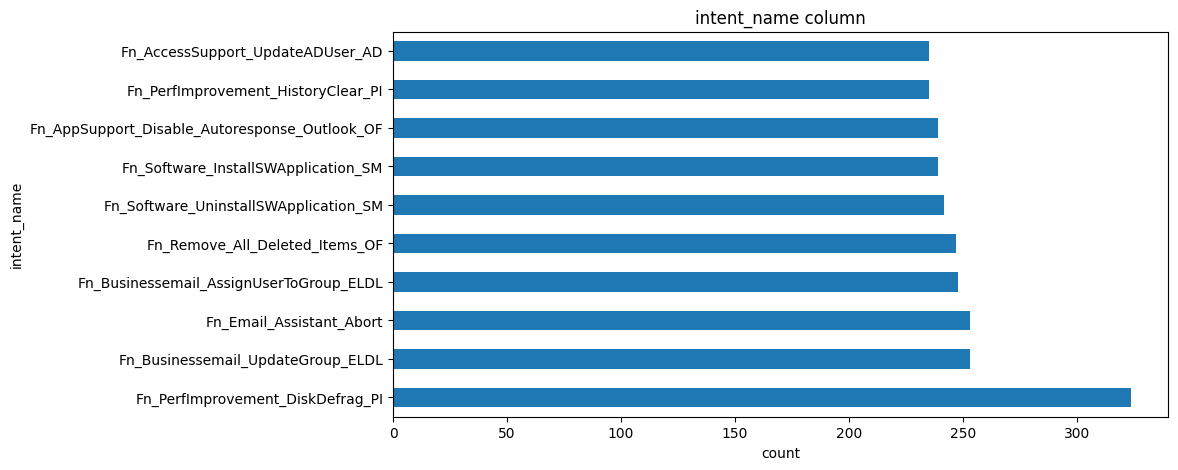

In [18]:
#plotting the graph

plt.figure(figsize=(10,5))
data['intent_name'].value_counts()[:10].plot(kind='barh')
plt.title('intent_name column')
plt.xlabel('count')
plt.ylabel('intent_name')
plt.show()

In [19]:
def print_message(index):
    example = data[data.index == index][['phrases', 'intent_name']].values[0]
    if len(example) > 0:
        print(example[0])
        print('phrases:', example[1])

print_message(25)

List out number of IT services provided by company
phrases: FnIT_MainMenu


In [20]:
print_message(5)

Further Assistance is Required
phrases: Further_Help_Required


In [21]:
nltk.download('stopwords')

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text


# Apply cleaning
data['clean_text'] = data['phrases'].apply(clean_text)
data['clean_text']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                assistance required
1            dont require assistance
2                      help required
3               dont need assistance
4            dont require assistance
                    ...             
11100                           halt
11101                           quit
11102                 drop operation
11103               put halt process
11104    stop operations immediately
Name: clean_text, Length: 11038, dtype: object

In [22]:
# Separate X and y

X = data['clean_text']
y = pd.get_dummies(data['intent_name'])

In [23]:
print("Shape of X:",X.shape)
print("Shape of y:",y.shape)

Shape of X: (11038,)
Shape of y: (11038, 59)


In [25]:
# Tokenize the text

max_features = 5000
tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

In [26]:
X

0                assistance required
1            dont require assistance
2                      help required
3               dont need assistance
4            dont require assistance
                    ...             
11100                           halt
11101                           quit
11102                 drop operation
11103               put halt process
11104    stop operations immediately
Name: clean_text, Length: 11038, dtype: object

In [27]:
Tokenizer_vocab_size = len(tokenizer.word_index) + 1
print("Tokenizer vocabulary size:",Tokenizer_vocab_size)

Tokenizer vocabulary size: 1624


In [28]:
len(max(X, key=len))

138

In [29]:
print("(Input->Sentence) Length of X:",X.shape) # Input -> Input
print("(output->Labels) Length of y:",y.shape) # output -> Labels

(Input->Sentence) Length of X: (11038,)
(output->Labels) Length of y: (11038, 59)


In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (7726,), y_train shape: (7726, 59)
X_val shape: (3312,), y_val shape: (3312, 59)


In [31]:
print("(Input->Sentence) Length of X_train:",X_train.shape) # Input -> Input
print("(output->Labels) Length of y_train:",y_train.shape) # output -> Labels

(Input->Sentence) Length of X_train: (7726,)
(output->Labels) Length of y_train: (7726, 59)


In [32]:
# Encoding Operation--->Turn text into a numerical array(using Tokenizer.texts_to_sequences)--->Uses Tokenizer_word_index.
X_train_encoded_words = tokenizer.texts_to_sequences(X_train)
X_val_encoded_words = tokenizer.texts_to_sequences(X_val)

In [33]:
print("(output->Labels) Length of Y_train:",y_train.shape) # output -> Labelsprint("(Input->Sentence) Length of X_train:",len(X_train_encoded_words)) # Input -> Input

(output->Labels) Length of Y_train: (7726, 59)


In [35]:
max_len = 100

X_train_encoded_padded_words = pad_sequences(X_train_encoded_words, maxlen=max_len, padding='post')
X_val_encoded_padded_words = pad_sequences(X_val_encoded_words, maxlen=max_len, padding='post')

In [36]:
print("(Input->Sentence) Length of X_train:",X_train_encoded_padded_words.shape) # Input -> Input
print("(output->Labels) Length of y_train:",y_train.shape) # output -> Labels

(Input->Sentence) Length of X_train: (7726, 100)
(output->Labels) Length of y_train: (7726, 59)


In [37]:
X_train_encoded_padded_words

array([[  46,  224,    5, ...,    0,    0,    0],
       [  22,   55,   18, ...,    0,    0,    0],
       [  17,  224,  430, ...,    0,    0,    0],
       ...,
       [1336,   28,  741, ...,    0,    0,    0],
       [  12,   25,   40, ...,    0,    0,    0],
       [  22,    4,  166, ...,    0,    0,    0]], dtype=int32)

In [38]:
X_val_encoded_padded_words

array([[   3,   19,   98, ...,    0,    0,    0],
       [  17,   32,   16, ...,    0,    0,    0],
       [ 118,   78,   24, ...,    0,    0,    0],
       ...,
       [ 697,   95,   23, ...,    0,    0,    0],
       [  33,   11,  167, ...,    0,    0,    0],
       [1137,  360,    0, ...,    0,    0,    0]], dtype=int32)

In [39]:
print(y_train.shape)
print(y_val.shape)

(7726, 59)
(3312, 59)


In [40]:
# Build the model
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.3))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 100)          0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 24, 128)           0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 24, 256)           263168    
 al)                                                             
                                                        

In [42]:
# Compile the model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('models/vtech_model.h5', save_best_only=True, monitor='val_loss', mode='min')

In [44]:
print(X_train_encoded_padded_words.shape)
print(y_train.shape)

print(X_val_encoded_padded_words.shape)
print(y_val.shape)

(7726, 100)
(7726, 59)
(3312, 100)
(3312, 59)


In [45]:
# Train the model
epochs = 30
batch_size = 64
history = model.fit(X_train_encoded_padded_words, y_train, epochs=epochs, batch_size=batch_size, verbose=1,
                    validation_data=(X_val_encoded_padded_words, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
121/121 [==============================] - ETA: 0s - loss: 4.0121 - accuracy: 0.0227

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 [==============================] - 61s 366ms/step - loss: 4.0121 - accuracy: 0.0227 - val_loss: 3.8020 - val_accuracy: 0.0365
Epoch 2/30
121/121 [==============================] - 36s 296ms/step - loss: 3.3071 - accuracy: 0.1052 - val_loss: 2.3588 - val_accuracy: 0.3285
Epoch 3/30
121/121 [==============================] - 38s 316ms/step - loss: 2.0048 - accuracy: 0.3752 - val_loss: 1.0375 - val_accuracy: 0.7286
Epoch 4/30
121/121 [==============================] - 37s 305ms/step - loss: 1.1234 - accuracy: 0.6320 - val_loss: 0.5144 - val_accuracy: 0.8720
Epoch 5/30
121/121 [==============================] - 39s 324ms/step - loss: 0.6794 - accuracy: 0.7857 - val_loss: 0.3114 - val_accuracy: 0.9245
Epoch 6/30
121/121 [==============================] - 36s 294ms/step - loss: 0.4553 - accuracy: 0.8606 - val_loss: 0.2389 - val_accuracy: 0.9366
Epoch 7/30
121/121 [==============================] - 36s 297ms/step - loss: 0.3329 - accuracy: 0.9009 - val_loss: 0.2072 - val_accuracy: 0.9

In [46]:
# Evaluate on validation set

score = model.evaluate(X_val_encoded_padded_words, y_val, verbose=1)
print('Test accuracy:', score[1])

104/104 [==============================] - 3s 28ms/step - loss: 0.1709 - accuracy: 0.9638
Test accuracy: 0.9637681245803833


In [47]:
# Predict function
def predict_intent(text, model, tokenizer, max_len=100):
    cleaned_text = clean_text(text)
    encoded_text = tokenizer.texts_to_sequences([cleaned_text])
    padded_text = pad_sequences(encoded_text, maxlen=max_len, padding='post')
    prediction = model.predict(padded_text)
    intent = y.columns[np.argmax(prediction)]
    return intent

In [63]:
# Example prediction
example_text = "My mailbox is overflowing, and I can't seem to delete enough emails to free up space. Can you help me empty it out?"
predicted_intent = predict_intent(example_text, model, tokenizer, max_len=100)
print(f'Predicted intent: {predicted_intent}')

1/1 [==============================] - 0s 48ms/step
Predicted intent: Fn_Mail_Box_Full_OF


In [49]:
# Save the tokenizer
import pickle
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Testing

In [65]:
# Load the model
model = load_model('models/vtech_model.h5')

# Load the tokenizer
import pickle
with open('models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Define text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

# Predict function
def predict_intent(text, model, tokenizer, max_len=100):
    cleaned_text = clean_text(text)
    encoded_text = tokenizer.texts_to_sequences([cleaned_text])
    padded_text = pad_sequences(encoded_text, maxlen=max_len, padding='post')
    prediction = model.predict(padded_text)
    intent = y.columns[np.argmax(prediction)]
    return intent

# Example prediction
example_text = "My mailbox is overflowing, and I can't seem to delete enough emails to free up space. Can you help me empty it out?"
predicted_intent = predict_intent(example_text, model, tokenizer, max_len=100)
print(f'Predicted intent: {predicted_intent}')

1/1 [==============================] - 0s 491ms/step
Predicted intent: Fn_Mail_Box_Full_OF
